In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
#my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
#tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

from model import UNet
from data import EMData
import matplotlib.pyplot as plt

In [3]:
# Data

emdata = EMData(data_path='./../data/em_segmentation')

# NOTE: this should be executed at the beginning
#emdata.unpack(overwrite=True, save_as='.png')

In [4]:
# Load data for training (using generators)

#train_data = emdata.load_training_data(
#    data_augmentation={
#        'rotation_range': 45,
#        'brightness_range': [0.5, 1],
#        'rescale': 1./255,
#        'shear_range': 0.15,
#        'zoom_range': 0.5,
#        'horizontal_flip': True,
#        'vertical_flip': True,
#        'fill_mode': 'reflect'
#    },
#    batch_size=1,
#    color_mode=('grayscale', 'grayscale'),
#    classification='binary',
#    seed=1527999
#)

# set up the generator indicating which data augmentation processing we would like to apply,
# and whether we want to dedicate a small proportion of our dataset to validation tests.
emdata.set_generator_up(
    data_augmentation={
        'rotation_range': 45,
        'brightness_range': [0.5, 1],
        'rescale': 1./255,
        'shear_range': 0.15,
        'zoom_range': 0.5,
        'horizontal_flip': True,
        'vertical_flip': True,
        'fill_mode': 'reflect',
        
        # 20% validation
        'validation_split': 0.17
    }
)

# configuration
generator_opts = dict(
    binary_labels=0.5, # y data should be composed of 0/1 only 
    color_mode='grayscale', # we're working with B/W images
    target_size=(512, 512), # width and height of each image
    batch_size=1,
    seed=6666
)
train_data = emdata.generate_train_data(**generator_opts)
valid_data = emdata.generate_valid_data(**generator_opts)

A subset will be used for validation purposes (17.0%)


In [4]:
## data test for binary output
#X, y = next(train_data)
#X_v, y_v = next(valid_data)

## Quick test: is y data binary?
#print(((y==0) | (y==1)).all())
#print(((y_v==0) | (y_v==1)).all())

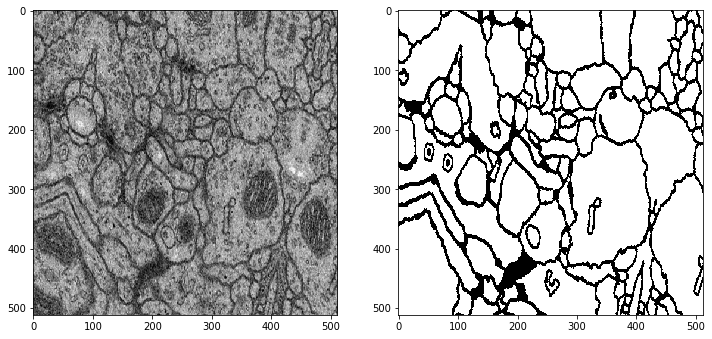

In [4]:
#plt.imshow((X[0] * 255).astype('int')) # RGB
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow((X[0].reshape(512, 512) * 255).astype('int'), cmap='gray') # grayscale
plt.subplot(1, 2, 2)
plt.imshow((y[0].reshape(512, 512) * 255).astype('int'), cmap='gray') # grayscale

In [5]:
# Run
COLOR_MODE = {'grayscale': 1, 'rgb': 3, 'rgba': 4}
IMG_COLOR_MODE = COLOR_MODE['grayscale']
IMG_SIZE = (512, 512)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], IMG_COLOR_MODE) # input
OUTPUT_SHAPE = 1 # n_classes
CLASSIFICATION = 'binary'

unet = UNet(INPUT_SHAPE, OUTPUT_SHAPE, CLASSIFICATION)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
## Train & Validation
EPOCHS = 2 #5
STEPS_PER_EPOCH = 10 #200

history = unet.train(
    train_data, 
    #val_data=valid_data, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    model_checkpoint=True
)

Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
  ...
    to  
  ['...']
Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
  ...
    to  
  ['...']
Train for 10 steps
Epoch 1/2
10/10 - 387s - loss: 0.4077 - accuracy: 0.7465


KeyboardInterrupt: 

In [21]:
# Load weights from checkpoint folder or .h5 file
unet.load_weights('./checkpoints')
#unet.load_weights('weights.h5')

Restoring weights from ./checkpoints


In [ ]:
# Predict on Test data

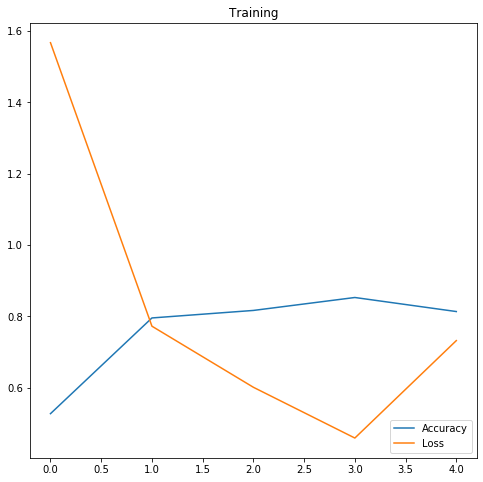

In [9]:
# show some history...
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()